# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matrix with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

%matplotlib inline

# Setup Seaborn
#sns.set_style("whitegrid")
#sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### 1b. Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/Users/astrodoo/opt/anaconda3/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [5]:
print(np.shape(df_offers), np.shape(df_transactions))

(32, 7) (324, 3)


In [6]:
''' merge the dataset '''
df_merged = df_offers.merge(df_transactions, on='offer_id', how='inner')
print("Shape of merged dataset: {}".format(np.shape(df_merged)))
df_merged.head()

Shape of merged dataset: (324, 9)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [7]:
df_customer_offers = df_merged.pivot_table(values='n', index='customer_name', columns='offer_id', fill_value=0)

# re-arrange the index so that the data has required columns -> move 'customer_name' from index to column
df_customer_offers.reset_index(inplace=True)

# print-out some info
print("Shape of pivot dataset: {}".format(np.shape(df_customer_offers)))
df_customer_offers.head()

Shape of pivot dataset: (100, 33)


offer_id,customer_name,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: ***the Elbow method***, ***the Silhouette method*** and ***the gap statistic***.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

**Q)** What values of  𝑆𝑆  do you believe represent better clusterings? Why?

> **Answer)** I would expect the reasonably small value of *SS* (Sum-of-Squares) if the clustering is quite good. It is because the sum of distance sqaures to the centroid would be quite small if the centroid is well representative for each cluster. However, it should be careful to overfit the data where the number of clusters are too many. In this case, even though *SS* is very small, the clustering would not be good.

**Q)** Create a numpy matrix `x_cols` with only the columns representing the offers (i.e. the 0/1 colums)

In [8]:
x_cols = df_customer_offers.drop(columns='customer_name').to_numpy()
print('Shape of offers numpy dataset: {}'.format(np.shape(x_cols)))

Shape of offers numpy dataset: (100, 32)


**Q)** 
- Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.
- Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.

In [9]:
Ks = np.arange(2,11)  # range of K

SS    = np.zeros_like(Ks)
cluster_labels_Ks = np.zeros((len(Ks),len(x_cols)))   

for i, K in enumerate(Ks):
    model = KMeans(n_clusters=K, random_state=10)
    model.fit(x_cols)
    cluster_labels_Ks[i] = model.labels_ # here, the same as model.predict(x_cols)
    SS[i] = model.inertia_

<div class="alert alert-warning">
    In general, clustering uses `model.labels_` rather than `model.predict(X)` except for K-Means. By fitting, the result is computed with affinity propagation. But, if one invoke `model.predict()`, it is not actually doing affinity propagation, but finding the nearest exaemplar for each point. So most clustering cases, `model.labels_` value can be different from `model.predict()` value. For K-means clustering, however, it may be safe to use both because it uses the nearest-center logic.  See [discussion in stackoverflow](https://stackoverflow.com/questions/53900542/affinitypropagation-labels-vs-predict)
</div>

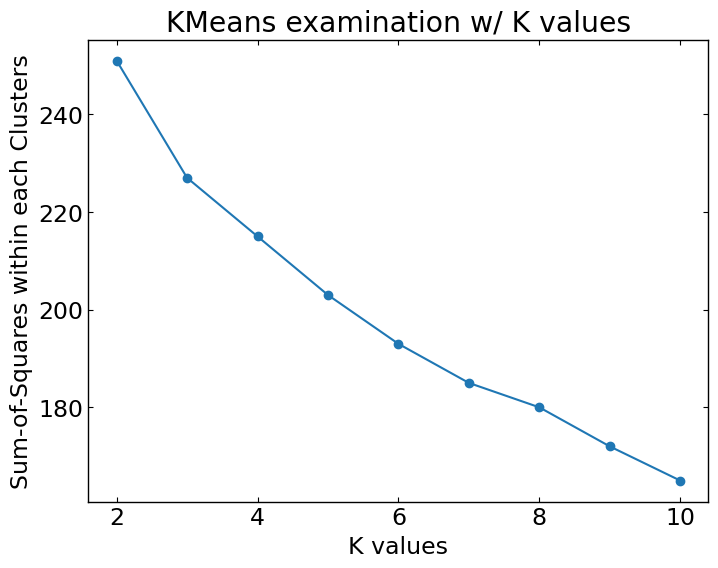

In [10]:
fig, ax = plt.subplots()

ax.plot(Ks, SS, 'o-')
ax.set_xlabel('K values')
ax.set_ylabel('Sum-of-Squares within each Clusters')
ax.set_title('KMeans examination w/ K values');

**Q)** Make a bar chart showing the number of points in each cluster for k-means under the best 𝐾.

> **Answer)** It is difficult to decide the best K because there is no apparent elbow point in the plot above. I chose K=3,4,5 as a possible best model. The bar charts are as follows.

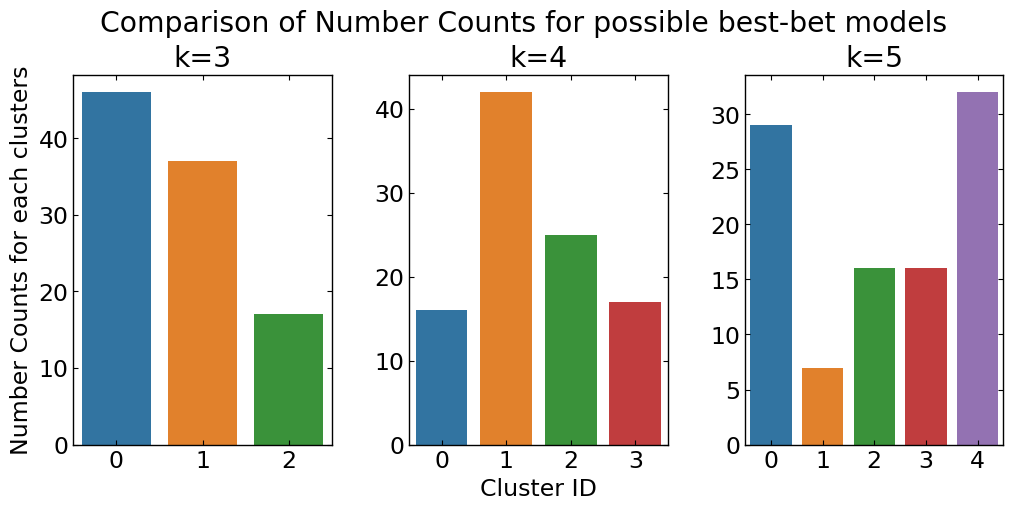

In [11]:
# generate dataframe that contains K-values and the corresponding predicted values
df_clusters = pd.DataFrame({int(k):labels for k, labels in zip(Ks, cluster_labels_Ks)})  
df_clusters = df_clusters.astype(int)   # type conversion from float to integer

# draw the bar charts
fig, axes = plt.subplots(1,3, figsize=(12,5))

sns.countplot(x=df_clusters.loc[:,3],ax=axes[0])
axes[0].set_ylabel('Number Counts for each clusters')
axes[0].set_xlabel('')
axes[0].set_title('k={:d}'.format(3))

sns.countplot(x=df_clusters.loc[:,4],ax=axes[1])
axes[1].set_ylabel('')
axes[1].set_xlabel('Cluster ID')
axes[1].set_title('k={:d}'.format(4))

sns.countplot(x=df_clusters.loc[:,5],ax=axes[2])
axes[2].set_ylabel('')
axes[2].set_xlabel('')
axes[2].set_title('k={:d}'.format(5))

fig.suptitle('Comparison of Number Counts for possible best-bet models')

# adjust spaces between subplots
fig.subplots_adjust(wspace=0.3, top=0.85)

**Q)** What challenges did you experience using the Elbow method to pick 𝐾?

> **Answer)** There was no apparent elbow points in the plot of sum-of-squares (SS) with respect to K-values. 

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

For n_clusters = 2, the average silhouette_score is : 0.09365573283492713
For n_clusters = 3, the average silhouette_score is : 0.11889942863638556
For n_clusters = 4, the average silhouette_score is : 0.12347053919571699
For n_clusters = 5, the average silhouette_score is : 0.14092516241984757
For n_clusters = 6, the average silhouette_score is : 0.1371798939109807
For n_clusters = 7, the average silhouette_score is : 0.1161092456616906
For n_clusters = 8, the average silhouette_score is : 0.11339573832632867
For n_clusters = 9, the average silhouette_score is : 0.12505960527779877
For n_clusters = 10, the average silhouette_score is : 0.11928332134753233


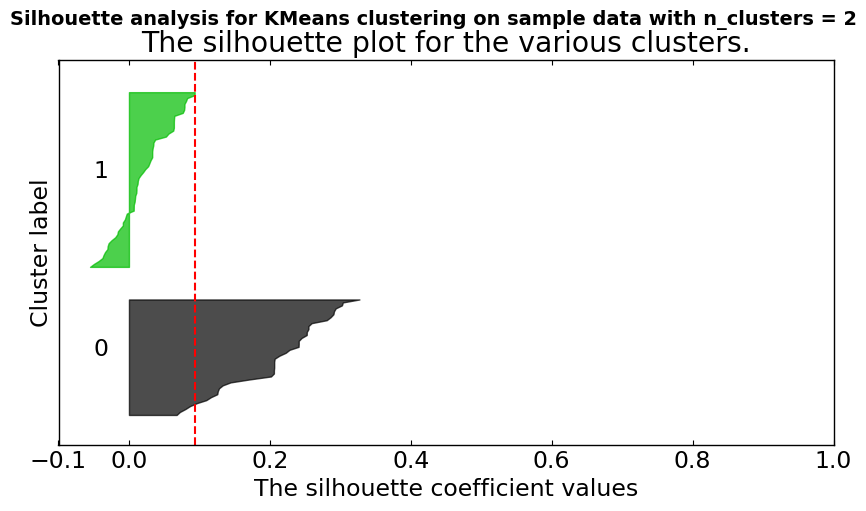

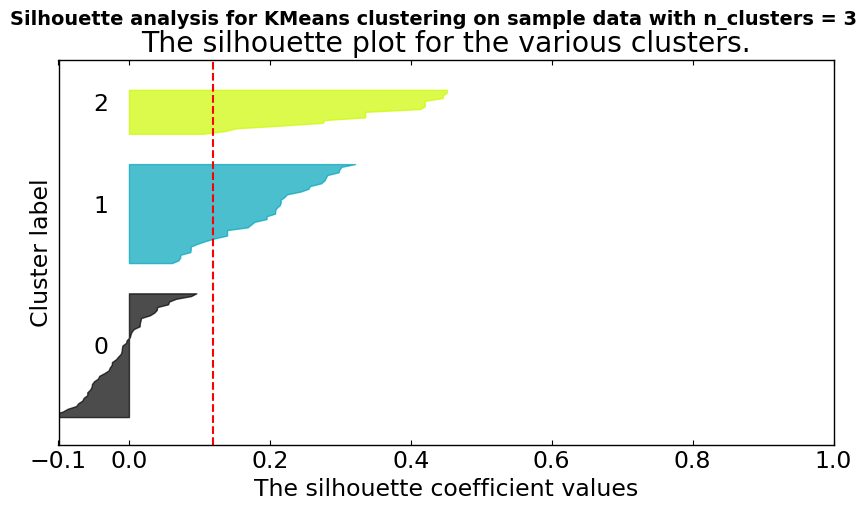

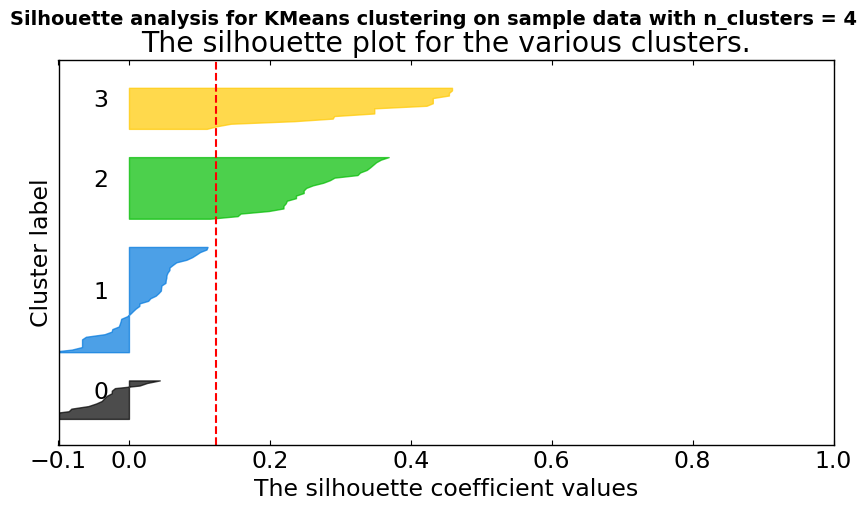

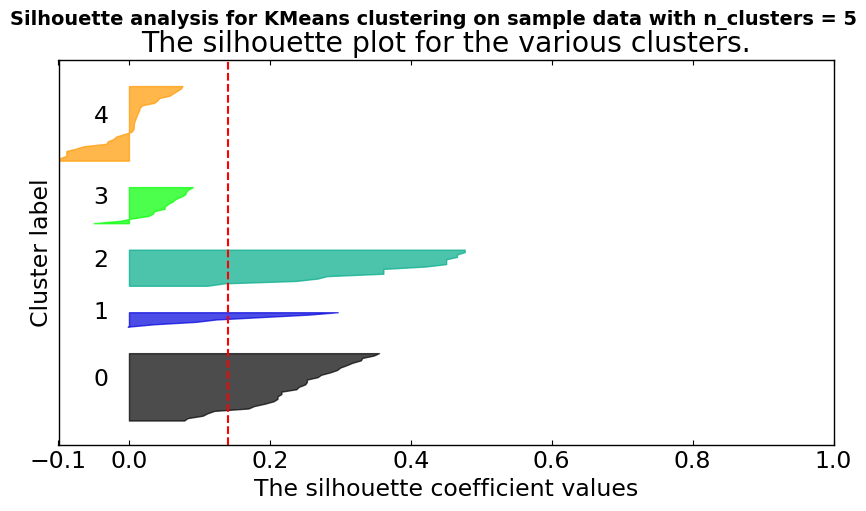

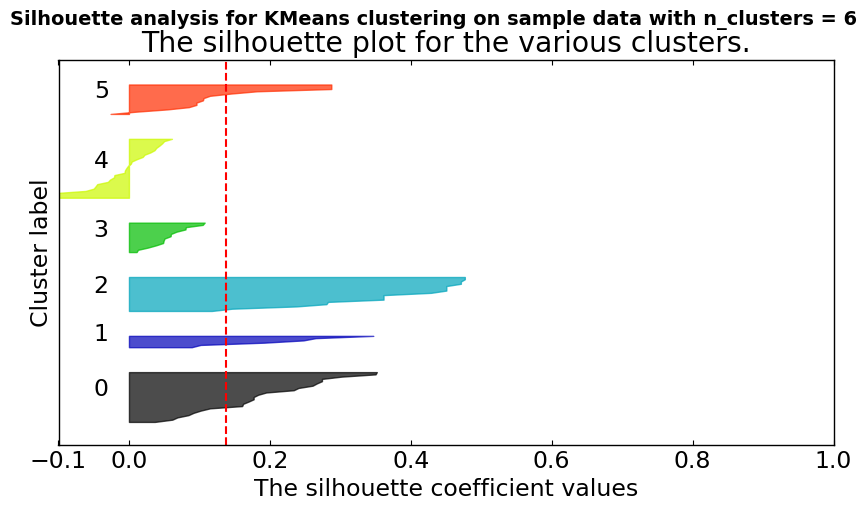

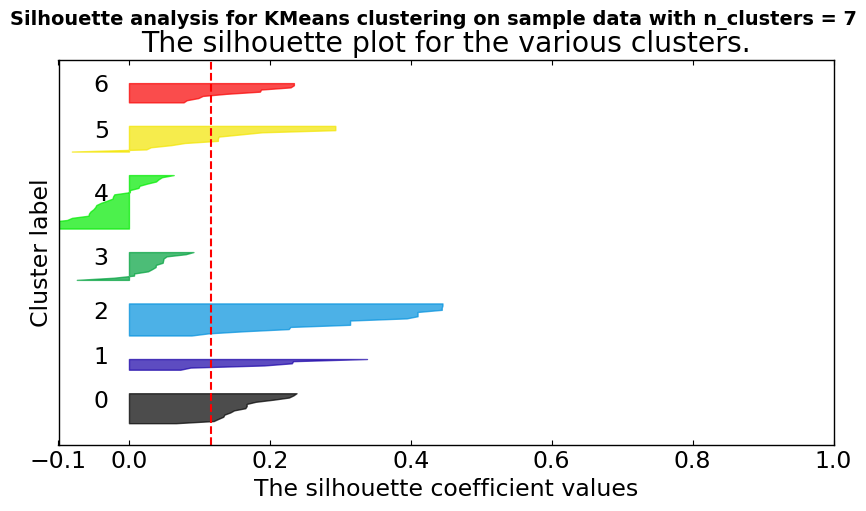

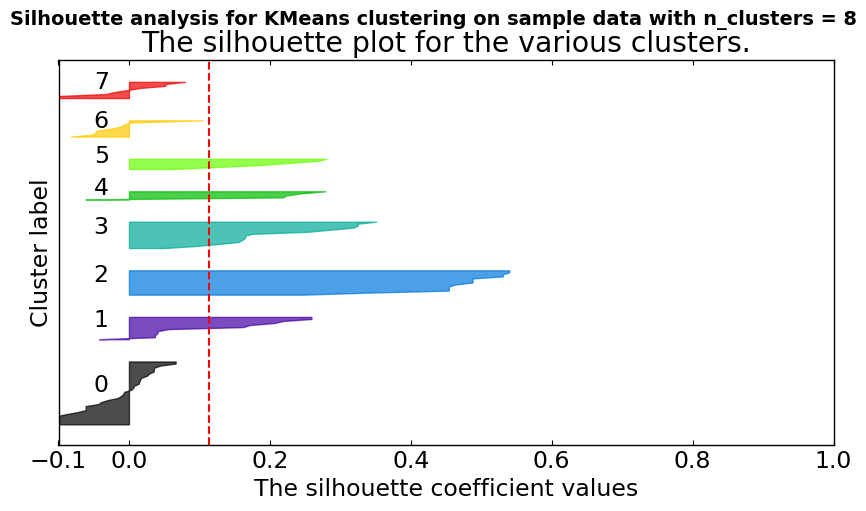

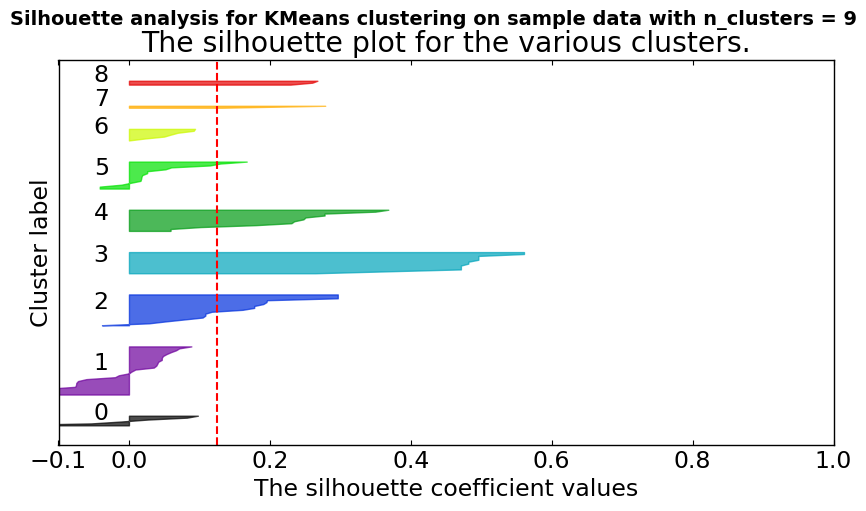

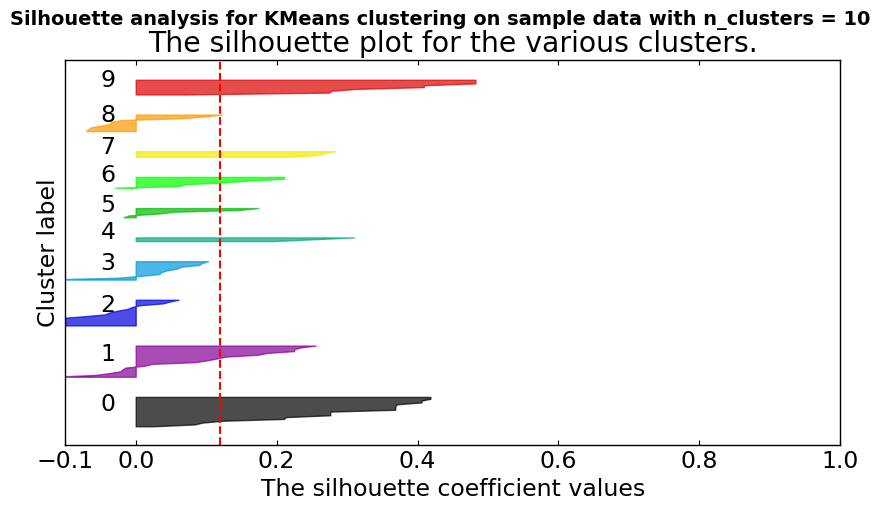

In [12]:
# initialize the silhouette_scores variable to save the calcuated scores
silhouette_scores = np.empty(len(Ks), dtype=np.float64)

# variables for the algorithm comparison at the end
best_Kmeans_k = 0
best_Kmeans_score = 0.

for i, n_clusters in enumerate(Ks):
    # Create a subplot with 1 row and 2 columns
    fig, ax = plt.subplots(figsize=(10,5))
    
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n_clusters,silhouette_avg))
    silhouette_scores[i] = silhouette_avg

    if (silhouette_avg > best_Kmeans_score):
        best_Kmeans_k = n_clusters
        best_Kmeans_score = silhouette_avg
        
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, \
            facecolor=color,edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    fig.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = {:d}".format(n_clusters), \
        fontsize=14, fontweight="bold",)

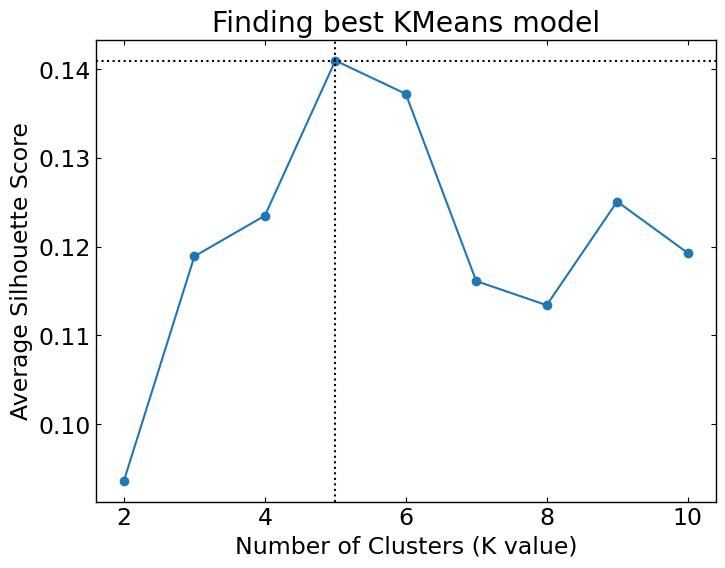

In [13]:
''' plotting the average silhouette scores '''

fig, ax = plt.subplots()

ax.plot(Ks, silhouette_scores, 'o-')

ax.axvline(x=5,linestyle=':',color='k')
ax.axhline(y=silhouette_scores[np.where(Ks==5)[0][0]],linestyle=':', color='k')

ax.set_xlabel('Number of Clusters (K value)')
ax.set_ylabel('Average Silhouette Score')
ax.set_title('Finding best KMeans model');

> **Answer)** As seen the Silhouette plots, the best model is the one with 5 clusters (K=5) as it has highest Silhouette score.  

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

> For this exercise, I will use the cluster id from the model with K=5, which was shown as best-bet model.

In [14]:
cluster_id = df_clusters.loc[:,5]  # cluster labels with K=5
customer_names = df_customer_offers.customer_name # customer name

pca = PCA(n_components=2)
comps = pca.fit_transform(x_cols)

df_pca = pd.DataFrame({'customer_name':customer_names, 'cluster_id':cluster_id, 'x':comps[:,0], 'y':comps[:,1]})
df_pca.head()

,customer_name,cluster_id,x,y
0,Adams,0,1.007580,0.108215
1,Allen,4,-0.287539,0.044715
2,Anderson,2,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,3,0.088183,-0.471695


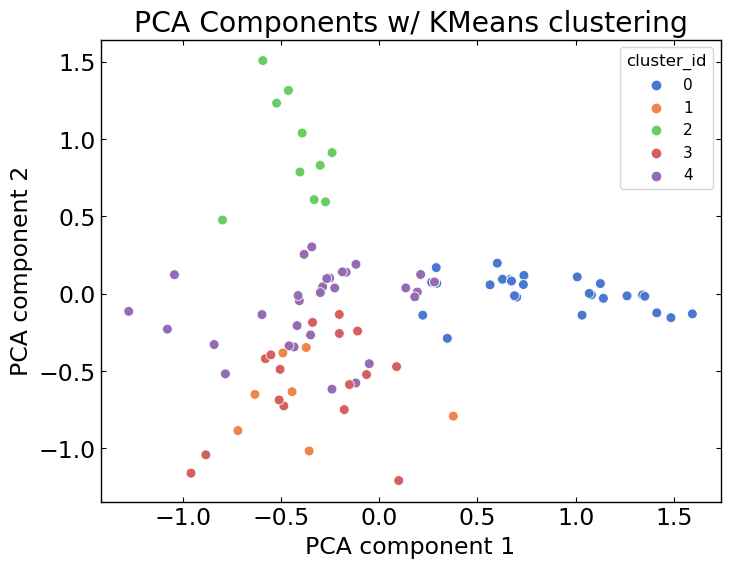

In [15]:
ax = sns.scatterplot(x='x', y='y', hue='cluster_id', s=50, data=df_pca, palette='muted')
ax.set_xlabel('PCA component 1')
ax.set_ylabel('PCA component 2')
ax.set_title('PCA Components w/ KMeans clustering')

# adjust fontsize
ax.legend(fontsize=11, title_fontsize=12, title='cluster_id');

> **Answer)** The clustering looks quite okay while there are some overlaps between cluster 1 (orange color) and cluster 2 (red color). It was very difficult to choose the proper K from the Elbow Method because the plot shows no apparent "elbow" shape. Alternatively, the Silhouette Method provide us insight that the model with K=5 would be our best-bet. 

**Q) Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?**

In [16]:
df_merged

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1
...,...,...,...,...,...,...,...,...,...
319,31,December,Champagne,72,89,France,False,Fisher,1
320,32,December,Cabernet Sauvignon,72,45,Germany,True,Young,1
321,32,December,Cabernet Sauvignon,72,45,Germany,True,Cooper,1
322,32,December,Cabernet Sauvignon,72,45,Germany,True,Gomez,1


In [17]:
df_all = df_merged.merge(df_pca, on='customer_name', how='inner')
df_all

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,cluster_id,x,y
0,1,January,Malbec,72,56,France,False,Thomas,1,4,-1.041879,0.122314
1,4,February,Champagne,72,48,France,True,Thomas,1,4,-1.041879,0.122314
2,9,April,Chardonnay,144,57,Chile,False,Thomas,1,4,-1.041879,0.122314
3,11,May,Champagne,72,85,France,False,Thomas,1,4,-1.041879,0.122314
4,14,June,Merlot,72,64,Chile,False,Thomas,1,4,-1.041879,0.122314
...,...,...,...,...,...,...,...,...,...,...,...,...
319,28,November,Cabernet Sauvignon,12,56,France,True,Hernandez,1,0,0.290130,0.168466
320,29,November,Pinot Grigio,6,87,France,False,Hernandez,1,0,0.290130,0.168466
321,29,November,Pinot Grigio,6,87,France,False,Cruz,1,0,0.736155,0.117752
322,30,December,Malbec,6,54,France,False,Cruz,1,0,0.736155,0.117752


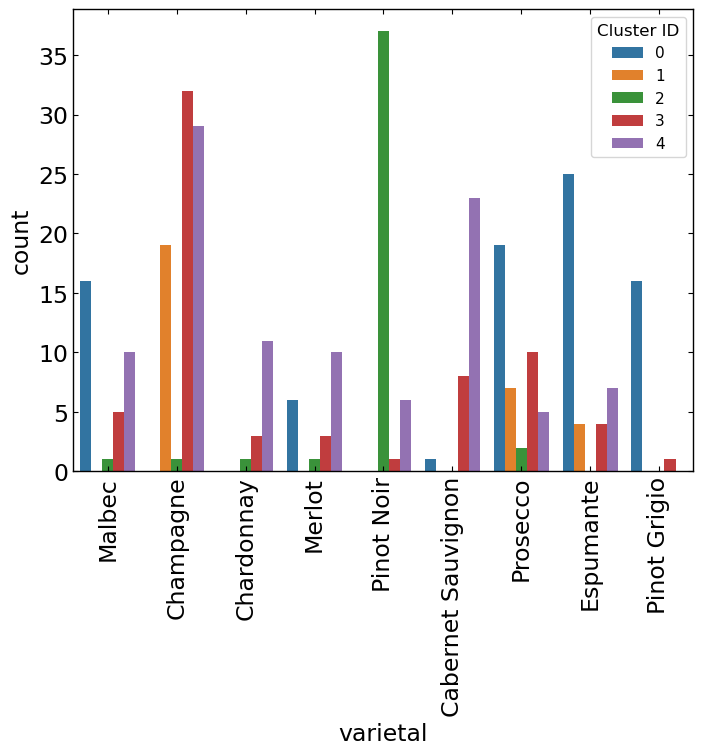

In [18]:
''' Counts for Wine variants per each cluster'''
ax = sns.countplot(x="varietal", hue="cluster_id", data=df_all)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc='upper right', fontsize=11, title_fontsize=12, title='Cluster ID');

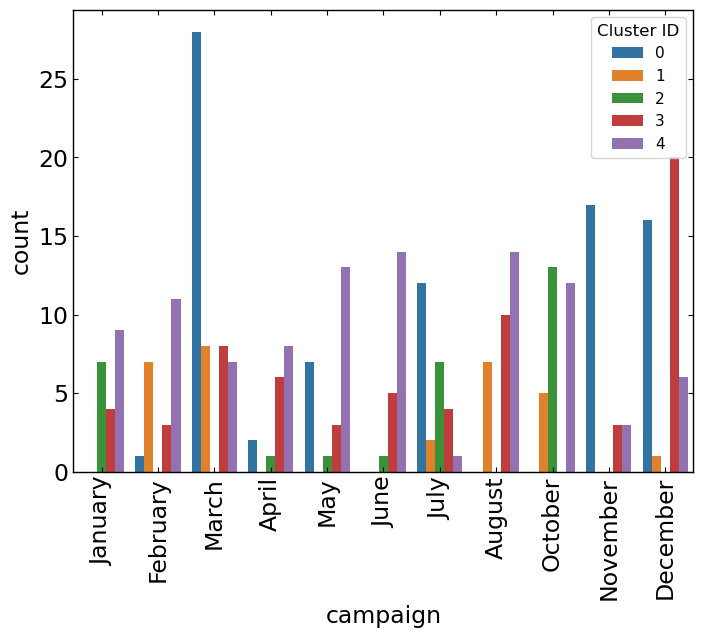

In [19]:
''' Counts for Campaign per each cluster'''

# order by Month
month_order = ["January","February","March","April","May","June","July","August","October","November","December"]
#df_all['campaign'] = pd.Categorical(df_all['campaign'], categories=month_order, ordered=True)

ax = sns.countplot(x="campaign", hue="cluster_id", order=month_order, data=df_all)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc='upper right', fontsize=11, title_fontsize=12, title='Cluster ID');

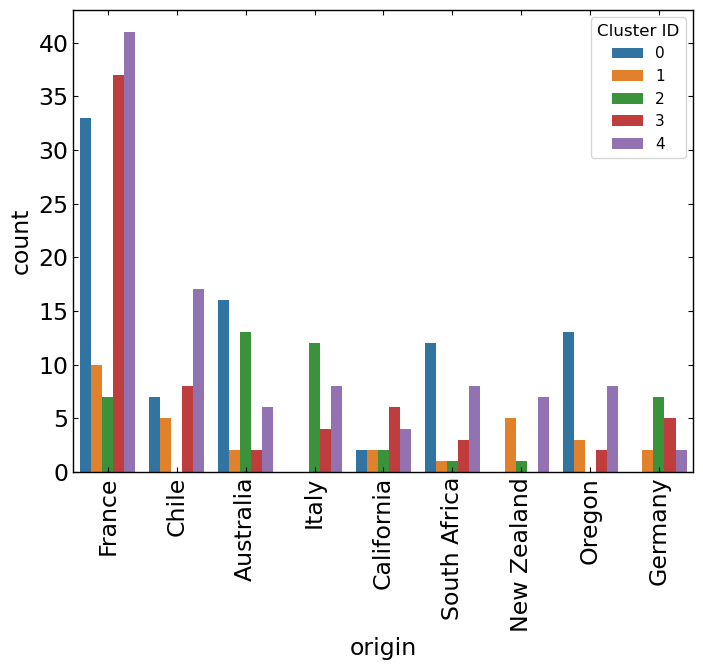

In [20]:
''' Counts for Wine variants per each cluster'''
ax = sns.countplot(x="origin", hue="cluster_id", data=df_all)
ax.tick_params(axis='x', rotation=90)
ax.legend(loc='upper right', fontsize=11, title_fontsize=12, title='Cluster ID');

> **Answer)** 

> It is obvious that Cluster 2 is dominant Pinot Noir consumers and and shows relatively small interest on the other wine variants. On the other hand, Cluster 3 mostly focus on Champagne over other wine variants, while it shows about 10 counts for Cabernet Sauvignon and Prosecco wines. Interestingly, Champagne is quite popular within Cluster 1,3,4, but Cluster 0,2 have very little interest on it. 

> There is no apparent pattern for Campaign, but we can see that Cluster 0 purchases increased number of wine in March. 

> One interesting observation is that while most Clusters are in favor of wines from France, Cluster 2, who is the group of Pinot Noir lovers, likes wines from Austrailia and Italy.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

In [21]:
#your turn
# Initialize a new PCA model with a default number of components.
pca = PCA()
pca.fit(x_cols)

print("Shape of x_cols: {}".format(np.shape(x_cols)))

Shape of x_cols: (100, 32)


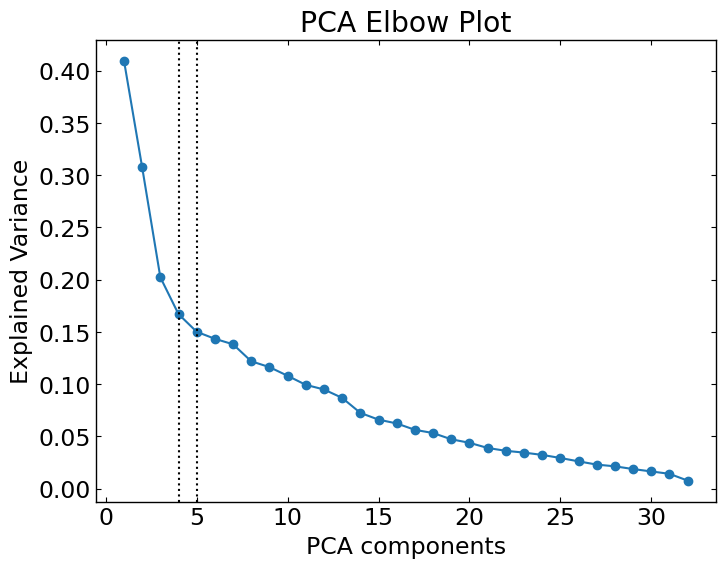

In [22]:
fig, ax = plt.subplots()

n_features = np.shape(x_cols)[1]    # number of columns
ax.plot(np.arange(1,n_features+1), pca.explained_variance_, 'o-')

# remark possible intrinsic dimension
ax.axvline(x=4, linestyle=':', color='k')
ax.axvline(x=5, linestyle=':', color='k')

ax.set_xlabel('PCA components')
ax.set_ylabel('Explained Variance')
ax.set_title('PCA Elbow Plot');

> **Answers)** The optimal number of dimensions is likely either of 4 or 5, beyond which the slope becomes shallow.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


In [23]:
''' Affinity Propagation '''

model_aff = AffinityPropagation(random_state=10)
labels_aff = model_aff.fit_predict(x_cols)

n_clusters_aff = len(np.unique(labels_aff))
print("Number of clusters: {}".format(n_clusters_aff))

silhouette_aff = silhouette_score(x_cols, labels_aff)
print("Silhouette Score: {}".format(silhouette_aff))

Number of clusters: 14
Silhouette Score: 0.12227751845150901


In [24]:
''' Spectral Clustering '''

# variable for the comparison
best_spec_k = 0
best_spec_score = 0.

for i, n_clusters in enumerate(Ks):
    model_spec = SpectralClustering(n_clusters=n_clusters, random_state=10)
    labels_spec = model_spec.fit_predict(x_cols)
    
    silhouette_spec = silhouette_score(x_cols, labels_spec)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n_clusters,silhouette_spec))
    
    if (silhouette_spec > best_spec_score):
        best_spec_k = n_clusters
        best_spec_score = silhouette_spec

For n_clusters = 2, the average silhouette_score is : 0.07631909829627558
For n_clusters = 3, the average silhouette_score is : 0.10611539040197304
For n_clusters = 4, the average silhouette_score is : 0.08627893400734331
For n_clusters = 5, the average silhouette_score is : 0.09915711813463922
For n_clusters = 6, the average silhouette_score is : 0.09847779745663406
For n_clusters = 7, the average silhouette_score is : 0.08299798621366726
For n_clusters = 8, the average silhouette_score is : 0.10795290206617342
For n_clusters = 9, the average silhouette_score is : 0.09119269817131899
For n_clusters = 10, the average silhouette_score is : 0.08294476827044912


In [25]:
''' Agglomerative clustering '''

# variable for the comparison
best_agg_k = 0
best_agg_score = 0.

for i, n_clusters in enumerate(Ks):
    model_agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    labels_agg = model_agg.fit_predict(x_cols)
    
    silhouette_agg = silhouette_score(x_cols, labels_agg)
    print("For n_clusters = {}, the average silhouette_score is : {}".format(n_clusters,silhouette_agg))
    
    if (silhouette_agg > best_agg_score):
        best_agg_k = n_clusters
        best_agg_score = silhouette_agg

For n_clusters = 2, the average silhouette_score is : 0.08258017823184984
For n_clusters = 3, the average silhouette_score is : 0.11625878863607858
For n_clusters = 4, the average silhouette_score is : 0.128937578158815
For n_clusters = 5, the average silhouette_score is : 0.14089739970831974
For n_clusters = 6, the average silhouette_score is : 0.1471521720461323
For n_clusters = 7, the average silhouette_score is : 0.15275152751051155
For n_clusters = 8, the average silhouette_score is : 0.15578053718604024
For n_clusters = 9, the average silhouette_score is : 0.12075124131971901
For n_clusters = 10, the average silhouette_score is : 0.09754750747147792


In [26]:
''' DBSCAN '''

model_db = DBSCAN(eps=1, min_samples=3).fit(x_cols)
core_samples_mask = np.zeros_like(model_db.labels_, dtype=bool)
core_samples_mask[model_db.core_sample_indices_] = True
labels_db = model_db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
n_noise_db = list(labels_db).count(-1)

# score
silhouette_db = silhouette_score(x_cols, labels_db)

print("Estimated number of clusters: {:d}".format(n_clusters_db))
print("Estimated number of noise points: {:d}".format(n_noise_db))
print("Silhouette Coefficient: {:f}".format(silhouette_db))

Estimated number of clusters: 4
Estimated number of noise points: 51
Silhouette Coefficient: 0.038316


Text(0.5, 1.0, 'Comparison of Clustering Algorithms')

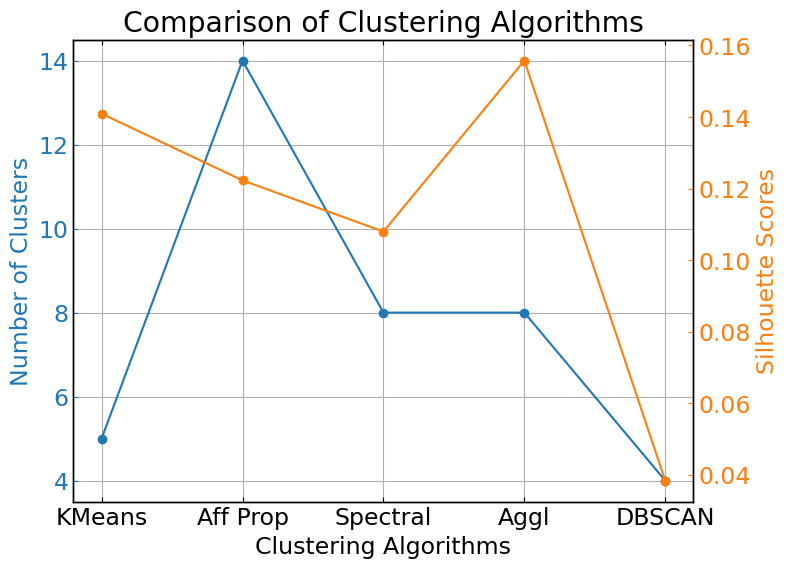

In [27]:
''' draw comparison plot '''
model_names = ['KMeans', 'Aff Prop', 'Spectral', 'Aggl', 'DBSCAN']
best_Ks = [best_Kmeans_k, n_clusters_aff, best_spec_k, best_agg_k, n_clusters_db]
best_scores = [best_Kmeans_score, silhouette_aff, best_spec_score, best_agg_score, silhouette_db]

fig, ax = plt.subplots()

p1, = ax.plot(model_names, best_Ks,'o-')
ax.grid()

ax.set_xlabel('Clustering Algorithms')
ax.set_ylabel('Number of Clusters')
ax.yaxis.label.set_color(p1.get_color())
ax.tick_params(axis='y', colors=p1.get_color())

twax = ax.twinx()
p2, = twax.plot(model_names, best_scores, 'o-' ,color='C1')
twax.set_ylabel('Silhouette Scores')
twax.yaxis.label.set_color(p2.get_color())
twax.tick_params(axis='y', colors=p2.get_color())

ax.set_title('Comparison of Clustering Algorithms');

**Answer)** The comparison plot shows that the `Agglomerative Clustering` algorithm works best for this modeling as it has the highest Silhouette score value. `K-Means Clustering` algorithm also performs well as its score is just a few percentile lower than the score for the `Agglomerative Clustering`. Given the dataset, `K-Means Clustering` works best when the number of clusters is 5, while other algorithms have more clusters. In particular, `Affinity Propagation` has 14 clusters, which looks too many for the data size of 100. Lastly, it is quite difficult to use `DBSCAN` algorithm for this case as it dumps lots of noises. I tried to adjust the size of neighbors, but the best silhouette score I could derive was still very poor compared to other algorithms. Note that for this benchmark, I only employed the silhouette score as an indicator, so the performance could be changed.  